In [ ]:
import kagglehub
import os

os.environ['KAGGLEHUB_CACHE'] = "./data"

# Download latest version
path = kagglehub.dataset_download("omsandeeppatil/indian-aqi-stations")
 
print("Path to dataset files:", path)

In [ ]:
!pip install scikit-learn torch pandas seaborn matplotlib

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import os
from sklearn.preprocessing import MinMaxScaler

In [5]:
data_dir = r"/kaggle/input/indian-aqi-stations" #if running on google colab
data_dir = r"./data" #if running locally

In [6]:
station_data = pd.read_csv(os.path.join(data_dir,"stations.csv"))

In [7]:
station_data.head()

,id,station_code,city,state_code,pin_code,latitude,longitude,elevation_m,topo_complexity,coastal_proximity,valley_factor
0,1,DL01,Dwarka,DL,110078,28.610948,77.038456,215,0.7,0.000000,0.80
1,2,DL02,New Delhi,DL,110006,28.628191,77.241044,212,0.7,0.000000,0.80
2,3,DL03,Delhi,DL,110042,28.750815,77.116277,217,0.7,0.000000,0.90
3,4,CG01,Pawaras,CG,486865,18.388855,81.683361,212,0.5,0.370772,0.60
4,5,RJ01,Alwar,RJ,356172,27.550006,76.611703,286,0.3,0.000000,0.95


In [8]:
data = pd.read_csv(os.path.join(data_dir,"Uttar_Pradesh/UP16.csv"))

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp']) # converting the timestamp column from string to datetime object

data.set_index('timestamp',inplace=True) # setting timestamp as the index
data.sort_index(inplace=True) #sorting the dataset to have days' data inorder

df_daily = data.resample('D').mean() #converting the data from 15minute intervals to daily intervals by taking mean of the whole day and replacing it with the day day

In [10]:
df_daily.isna().sum() # data does contain nan values

pm2.5        6
pm10         3
no          16
no2         12
so2          3
co         180
nox         11
ozone        6
at           4
rh           3
ws           2
wd           2
bp           2
nh3         11
benzene    482
toluene    488
dtype: int64

In [11]:
df_daily.interpolate(method="time") # filling the nan values by interpolating values between two non nan values 

# as the air quality in north does depend on the month (months near diwali face worse air quality due to crop burning and crackers)
df_daily['month'] = df_daily.index.month

# converting the month column into sin and cos waves so model can know the year is cyclic (like january and december are neighbours and winter months at which the pm2.5 peaks mostly)
df_daily['month_sin'] = np.sin(2*np.pi*(df_daily['month']/12)) # 2pi*(month/12)
df_daily['month_cos'] = np.cos(2*np.pi*(df_daily['month']/12))


In [12]:
# adding rolling window of 7 days so it can know when its peaking and when it is not in a week
# i.e average pollution level over the last 7 days (using moving average logic used in quantative strategies)
df_daily['rolling_mean_7d'] = df_daily['pm2.5'].rolling(window=7).mean()

# using the slope of changing values to calculate how rapidly is the AQI worsening/bettering itself
df_daily['pm2.5_slope'] = df_daily['pm2.5'].diff() #velocity of pm2.5 
df_daily['pm2.5_acc'] = df_daily['pm2.5_slope'].diff() #rate of change of velocity

In [13]:
#clearing nan values created by creating slope values
df_daily.dropna(inplace=True)

In [16]:
# checking how much data do we have now left
print("Original 15-min Shape:", data.shape)
print("New Daily Shape:", df_daily.shape)

Original 15-min Shape: (190911, 16)
New Daily Shape: (1478, 22)


In [18]:
df_daily.columns

Index(['pm2.5', 'pm10', 'no', 'no2', 'so2', 'co', 'nox', 'ozone', 'at', 'rh',
       'ws', 'wd', 'bp', 'nh3', 'benzene', 'toluene', 'month', 'month_sin',
       'month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc'],
      dtype='object')

rh - Humidity (makes everything stickier) (%)
ws - Wind speed (how fast help is blowing away) (m/s)
wd - Wind direction (where the blame is coming from) (°)
bp - Barometric pressure (atmospheric mood swings) (hPa)

In [19]:
# only keeping the columns which are useful and removing the rest
df_daily = df_daily[['pm2.5', 'ozone', 'at', 'rh','ws', 'wd', 'bp','month_sin','month_cos', 'rolling_mean_7d', 'pm2.5_slope', 'pm2.5_acc']]

In [20]:
df_daily.head()

,pm2.5,ozone,at,rh,ws,wd,bp,month_sin,month_cos,rolling_mean_7d,pm2.5_slope,pm2.5_acc
timestamp,,,,,,,,,,,,
2019-06-30,67.881720,77.996739,39.942105,39.105263,0.680000,178.052632,740.000000,1.224647e-16,-1.000000,51.385235,13.292247,8.810300
2019-07-01,58.301075,90.905926,38.048958,49.812500,0.581250,220.979167,740.114583,-5.000000e-01,-0.866025,57.447114,-9.580645,-22.872892
2019-07-02,59.574468,98.514353,37.425000,52.937500,0.665625,222.489583,740.250000,-5.000000e-01,-0.866025,60.597633,1.273393,10.854038
2019-07-06,26.625000,30.285161,33.215625,73.156250,0.626042,264.708333,740.000000,-5.000000e-01,-0.866025,44.943493,-9.078297,-8.625343
2019-07-07,31.769231,80.486022,33.994792,70.989583,0.488542,221.927083,740.000000,-5.000000e-01,-0.866025,39.784565,5.144231,14.222527


In [21]:
data = df_daily.copy()
train_size = int(.9*data.shape[0])
data_train = data[:train_size]
data_test = data[train_size:]

In [22]:
scaler_all = MinMaxScaler()
scaler_target = MinMaxScaler()
scaler_target.fit(data_train[['pm2.5']])

data_train_scaled = pd.DataFrame(scaler_all.fit_transform(data_train), 
                                 columns=data_train.columns, 
                                 index=data_train.index)

data_test_scaled = pd.DataFrame(scaler_all.transform(data_test), 
                                columns=data_test.columns, 
                                index=data_test.index)

In [23]:
def create_data(data,column,window_size=20,target_col="pm2.5",target_window_size=7):
    # converting to numpy because its faster
    np_data = data[column].values
    np_target = data[target_col].values
    x=[]
    y=[]
    n = data.shape[0]-window_size-target_window_size
    for i in range(n):
        x.append(np_data[i : i + window_size])
        y.append(np_target[i + window_size : i + window_size + target_window_size])
    return np.array(x),np.array(y)


In [24]:
x_train,y_train = create_data(data_train_scaled,["pm2.5","ws","wd","rh","at"])
x_test,y_test =create_data(data_test_scaled,["pm2.5","ws","wd","rh","at"])

In [25]:
class lstmModelgoesbrr(torch.nn.Module):
    def __init__(self,input_size=5,hidden_size=64,num_layers=2,output_size=7):
        super(lstmModelgoesbrr,self).__init__()
        self.hidden_size = hidden_size
        self.input_size =input_size
        self.num_layers= num_layers
        self.output_size = output_size
        # shape is(batch,seq,features) thus batch_first = True
        self.lstm = torch.nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True)
        self.fc = torch.nn.Linear(hidden_size,output_size)

    def forward(self,x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the LAST time step
        # We only care about the result after seeing all 30 days
        out = self.fc(out[:, -1, :]) 
        
        return out


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training device =",device)

training device = cpu


In [27]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [28]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

test_data = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [32]:
import torch.nn as nn
import torch.optim as optim

In [33]:
model = lstmModelgoesbrr()
model.to(device)

lstmModelgoesbrr(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

In [34]:
mse = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=1e-2)

In [35]:
num_epochs = 100
history_loss = [] # for the plot

In [ ]:
for epoch in range(num_epochs):
    model.train() #putting the model into training mode
    running_loss = 0

    for i,(inputs,targets) in enumerate(train_loader):
        # moving them onto same device as model
        inputs,targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad() # resetting the gradient from previous step
        
        outputs = model(inputs)

        loss = mse(outputs,targets) # calculate the loss

        loss.backward() # calculate the dW and db for change

        optimizer.step() # update the weights

        running_loss+=loss.item()

    epoch_loss = running_loss/len(train_loader) # avg loss for the epoch
    history_loss.append(epoch_loss)

    if (epoch+1)%5==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

print("Training Complete!")


Epoch [1/100], Loss: 0.086092
Epoch [6/100], Loss: 0.062412
Epoch [11/100], Loss: 0.057986
Epoch [16/100], Loss: 0.057186
Epoch [21/100], Loss: 0.055011
Epoch [26/100], Loss: 0.052844
Epoch [31/100], Loss: 0.050298
Epoch [36/100], Loss: 0.047050
Epoch [41/100], Loss: 0.047357
Epoch [46/100], Loss: 0.042155
Epoch [51/100], Loss: 0.038550
Epoch [56/100], Loss: 0.035666
Epoch [61/100], Loss: 0.033407
Epoch [66/100], Loss: 0.030182
Epoch [71/100], Loss: 0.027387
Epoch [76/100], Loss: 0.024276
Epoch [81/100], Loss: 0.021666
Epoch [86/100], Loss: 0.020455
Epoch [91/100], Loss: 0.019122
Epoch [96/100], Loss: 0.016685
Training Complete!


<Axes: >

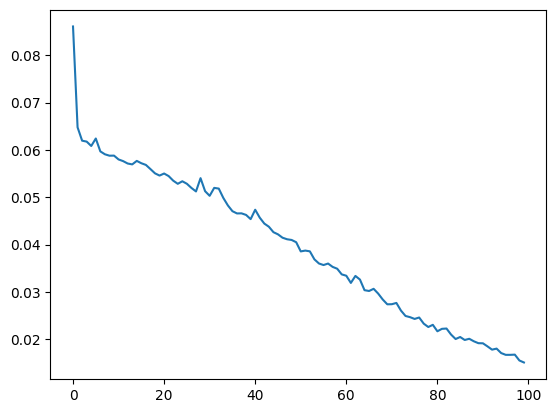

In [38]:
sns.lineplot(history_loss) # seeing the if the numer ofepochs need to be increased or not

In [39]:
model.eval() # put the model into evaluation mode

lstmModelgoesbrr(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)

In [40]:
# this tells the pytorch to not calculate gradient which saves memory
with torch.no_grad():
    x_test_tensor = x_test_tensor.to(device) # send the tensor to same device as model
    predictions = model(x_test_tensor)
    predictions = predictions.cpu().numpy() #send back the tensor to cpu so it can be converted to numbpy
    predictions = scaler_target.inverse_transform(predictions)

In [51]:
real_aqi_values = scaler_target.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1,1))

In [54]:
real_aqi_values.shape,predictions.shape

((2562, 1), (366, 7))

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

real_values_scaled = y_test_tensor.cpu().numpy() # sending the tensor back to cpu so it can be converted to numpy array

real_values = scaler_target.inverse_transform(real_values_scaled)

In [50]:
real_aqi_values[:,0]

array([210.7093  ,  35.545933, 192.90334 , ..., 340.63864 , 372.65994 ,
       139.19292 ], shape=(54900,), dtype=float32)

In [74]:
def plot_predictions(plot_df,sample_idx,error,folder='plots'):
    # reseting the plot
    plt.figure(figsize=(12, 6)) 
    sns.set_style("whitegrid")
    sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
    sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

    # filling the error gap between so we can see how bad it is or how good it is
    plt.fill_between(
        plot_df['Day'], 
        plot_df['Real Values'], 
        plot_df['Predictions'], 
        color='red', 
        alpha=0.2, 
        label='Error Gap'
    )

    if not os.path.exists(folder):
        os.mkdir(folder)

    plt.savefig(os.path.join(folder,"sample_"+str(sample_idx)+'_'+str(error)+".png"))
    plt.close()
    



In [77]:
area_errors = []
min_error_sample = 0
min_error = 0
for i in range(len(predictions)):
    sample_idx = i
    pred_7d = predictions[sample_idx]
    real_7d = real_values[sample_idx]
    days = np.arange(1,8) # day index

    plot_df = pd.DataFrame(
        {
            'Day':days,
            'Real Values':real_7d,
            'Predictions':pred_7d
        }
    )
    # finding the area between real prediction line and forecast prediction
    diff_curve = np.abs(real_7d - pred_7d)
    area_geometric = np.trapezoid(diff_curve, dx=1)
    area_errors.append(area_geometric)

    if min(area_errors) == area_geometric:
        min_error_sample = i
        min_error = area_geometric

    plot_predictions(plot_df,sample_idx,area_geometric)
    if (sample_idx+1)%round((len(predictions)/10))==0:
        print("plot progress:",sample_idx,"/",len(predictions),"(",round((sample_idx/len(predictions))*100,2),"%)")

print("minimum error in the sample",min_error_sample,"with error area of",min_error)

plot progress: 11 / 121 ( 9.09 %)
plot progress: 23 / 121 ( 19.01 %)
plot progress: 35 / 121 ( 28.93 %)
plot progress: 47 / 121 ( 38.84 %)
plot progress: 59 / 121 ( 48.76 %)
plot progress: 71 / 121 ( 58.68 %)
plot progress: 83 / 121 ( 68.6 %)
plot progress: 95 / 121 ( 78.51 %)
plot progress: 107 / 121 ( 88.43 %)
plot progress: 119 / 121 ( 98.35 %)
minimum error in the sample 37 with error area of 71.39277


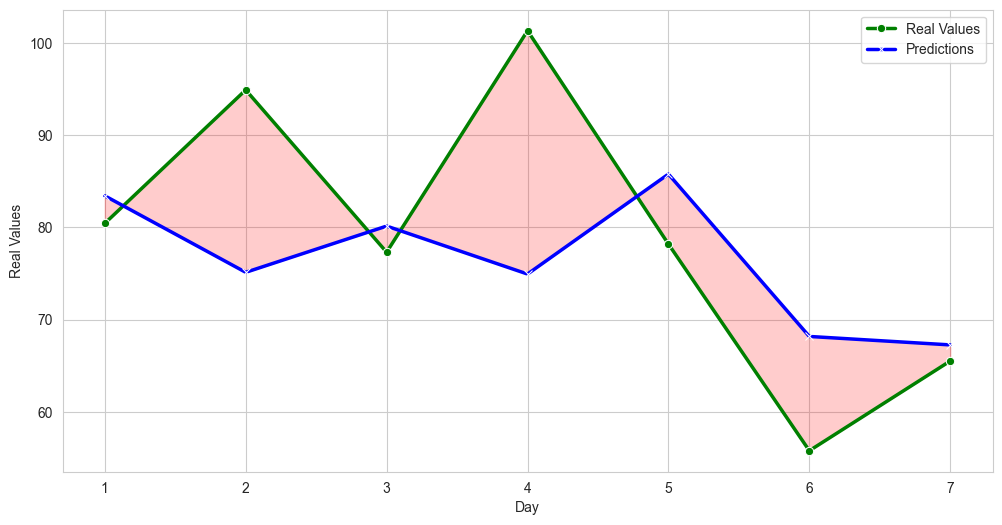

In [79]:
sample_idx = min_error_sample # choosing the index with minimum error area in the prediction set to visualize

pred_7d = predictions[sample_idx]
real_7d = real_values[sample_idx]
days = np.arange(1,8) # day index

plot_df = pd.DataFrame(
    {
        'Day':days,
        'Real Values':real_7d,
        'Predictions':pred_7d
    }
)
# reseting the plot
plt.figure(figsize=(12, 6)) 
sns.set_style("whitegrid")
sns.lineplot(plot_df,x='Day',y='Real Values',label="Real Values",color='green',marker='o',linewidth=2.5)
sns.lineplot(plot_df,x='Day',y='Predictions',label="Predictions",color='blue',marker='x',linewidth=2.5)

# filling the error gap between so we can see how bad it is or how good it is
plt.fill_between(
    plot_df['Day'], 
    plot_df['Real Values'], 
    plot_df['Predictions'], 
    color='red', 
    alpha=0.2, 
    label='Error Gap'
)
